# Imports

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile as zf
import re
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece

In [ ]:
!pip install transformers

In [ ]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub
import tensorflow.python.keras.backend as K
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import load_model
import bert
from transformers import AutoTokenizer

In [ ]:
# import os
# for dirname, _, filenames in os.walk('/content/drive/MyDrive/dataset/toxic-comment.zip'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [ ]:
train_Slice = pd.read_csv('/content/drive/MyDrive/dataset/toxic-comment.zip (Unzipped Files)/train.csv.zip')
test_data_Slice = pd.read_csv('/content/drive/MyDrive/dataset/toxic-comment.zip (Unzipped Files)/test.csv.zip')
test_labels_Slice = pd.read_csv('/content/drive/MyDrive/dataset/toxic-comment.zip (Unzipped Files)/test_labels.csv.zip')



In [ ]:
# cut down data rows from 154164 to 25,0000 for faster training
n =125000
train = train_Slice.iloc[:-n]
test_data = test_data_Slice.iloc[:-n]
test_labels = test_data_Slice.iloc[:-n]


In [ ]:
column_list = [f for f in train.columns if train.dtypes[f] != 'object']
df = pd.DataFrame(columns=column_list)
for col in column_list:
    df.loc[0,col] = train[train[col] == 1][col].sum() # Count the number of comments of each type
df['non_hate'] = train.shape[0] - df.sum(axis=1)    

In [ ]:
print(column_list)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


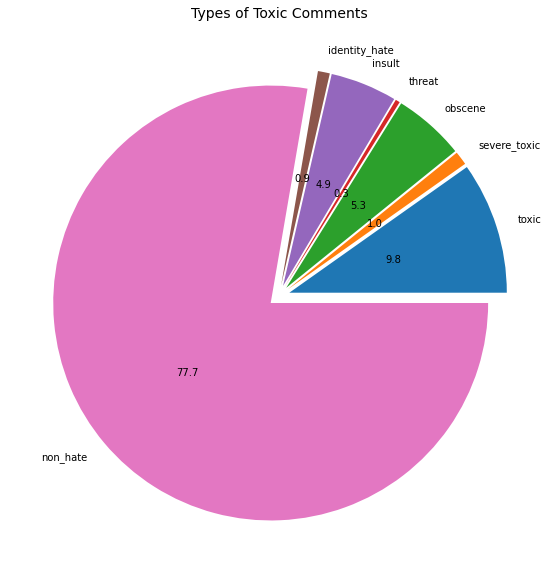

In [ ]:
pie, ax = plt.subplots(figsize=[12,10])
labels = df.keys()
plt.pie(x=df.values[0], autopct="%.1f", explode=[0.05]*len(df.values[0]), labels=labels, pctdistance=0.5)
plt.title("Types of Toxic Comments", fontsize=14);
pie.savefig("ToxicCommentsChart.png")

In [ ]:
df = train.drop(columns=['id'], axis=1)
print(df)

                                            comment_text  ...  identity_hate
0      Explanation\nWhy the edits made under my usern...  ...              0
1      D'aww! He matches this background colour I'm s...  ...              0
2      Hey man, I'm really not trying to edit war. It...  ...              0
3      "\nMore\nI can't make any real suggestions on ...  ...              0
4      You, sir, are my hero. Any chance you remember...  ...              0
...                                                  ...  ...            ...
34566  "\n\n The Source edit \n\nThis was clearly a p...  ...              0
34567  |class=Start|importance=Mid}}\n{{R&B; and Soul...  ...              0
34568  . I genuinely think there is room to get to co...  ...              0
34569  Arbitration on Dominion issue \n\nI've made an...  ...              0
34570  "\n Unblocking admin should see, the earlier b...  ...              0

[34571 rows x 7 columns]


# Preprocessing, (Cleaning the dataset)

In [ ]:
def clean_comment(comment):
    # Removing the @
    comment = re.sub(r"@[A-Za-z0-9]+", ' ', comment)
    # Removing the URL links
    comment = re.sub(r"https?://[A-Za-z0-9./]+", ' ', comment)
    # Keeping only letters
    comment = re.sub(r"[^a-zA-Z.!?']", ' ', comment)
    # Removing additional whitespaces
    comment = re.sub(r" +", ' ', comment)             
    return comment

In [ ]:
df['comment_text'] = df['comment_text'].apply(lambda x: clean_comment(x)) # Replace some special symbols

In [ ]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation Why the edits made under my userna...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,Hey man I'm really not trying to edit war. It'...,0,0,0,0,0,0
3,More I can't make any real suggestions on imp...,0,0,0,0,0,0
4,You sir are my hero. Any chance you remember w...,0,0,0,0,0,0


In [ ]:
data_clean = df.comment_text.values
data_labels = df.drop(columns=['comment_text'],axis=1).values

**Tokenization**

In [ ]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
#FullTokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def encode_sentence(sent):
    return ["[CLS]"] + tokenizer.tokenize(sent)[:510] + ["[SEP]"]
# https://albertauyeung.github.io/2020/06/19/bert-tokenization.html/

In [ ]:
data_inputs = [encode_sentence(sentence) for sentence in data_clean]

In [ ]:
print(data_inputs[10])

['[CLS]', 'fair', 'use', 'rational', '##e', 'for', 'image', 'won', '##ju', '.', 'jp', '##g', 'thanks', 'for', 'up', '##loading', 'image', 'won', '##ju', '.', 'jp', '##g', '.', 'i', 'notice', 'the', 'image', 'page', 'specifies', 'that', 'the', 'image', 'is', 'being', 'used', 'under', 'fair', 'use', 'but', 'there', 'is', 'no', 'explanation', 'or', 'rational', '##e', 'as', 'to', 'why', 'its', 'use', 'in', 'wikipedia', 'articles', 'constitutes', 'fair', 'use', '.', 'in', 'addition', 'to', 'the', 'boiler', '##plate', 'fair', 'use', 'template', 'you', 'must', 'also', 'write', 'out', 'on', 'the', 'image', 'description', 'page', 'a', 'specific', 'explanation', 'or', 'rational', '##e', 'for', 'why', 'using', 'this', 'image', 'in', 'each', 'article', 'is', 'consistent', 'with', 'fair', 'use', '.', 'please', 'go', 'to', 'the', 'image', 'description', 'page', 'and', 'edit', 'it', 'to', 'include', 'a', 'fair', 'use', 'rational', '##e', '.', 'if', 'you', 'have', 'uploaded', 'other', 'fair', 'use', '

# Dataset Creation

In [ ]:
def get_ids(tokens):
    return tokenizer.convert_tokens_to_ids(tokens)

def get_mask(tokens):
    return np.char.not_equal(tokens, "[PAD]").astype(int)

def get_segments(tokens):
    seg_ids = []
    current_seg_id = 0
    for tok in tokens:
        seg_ids.append(current_seg_id)
        if tok == "[SEP]":
            current_seg_id = 1-current_seg_id # turns 1 into 0 and vice versa
    return seg_ids

In [ ]:
data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]#enumerate,Form it into an index sequence, which can be used to get both the index and the value
random.shuffle(data_with_len)# random order
data_with_len.sort(key=lambda x: x[2])# Sort by the largest value of the second element
sorted_all = [([get_ids(sent_lab[0]),
                get_mask(sent_lab[0]),
                get_segments(sent_lab[0])],
               sent_lab[1])
              for sent_lab in data_with_len if sent_lab[2] > 7]

In [ ]:
print(data_with_len[0])

[['[CLS]', '[SEP]'], array([0, 0, 0, 0, 0, 0]), 2]


In [ ]:
# A list is a type of iterator so it can be used as generator for a dataset
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types=(tf.int32, tf.int32))

In [ ]:
BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE,
                                       padded_shapes=((3, None), (6)),
                                       padding_values=(0, 0))

In [ ]:
NB_BATCHES = math.ceil(len(sorted_all) / BATCH_SIZE)
NB_BATCHES_TEST = NB_BATCHES // 10   #  //means divisible
all_batched.shuffle(NB_BATCHES)  #random order
test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST) #The dataset is divided into test set and training set

## Model Building

In [ ]:
# https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4 documentation
class DCNNBERTEmbedding(tf.keras.Model):
    
    def __init__(self,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=6,
                 dropout_rate=0.1,
                 name="dcnn"):
        super(DCNNBERTEmbedding, self).__init__(name=name)
        
        self.bert_layer = hub.KerasLayer(
            "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
            trainable=False)

        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
#        if nb_classes == 2:
        self.last_dense = layers.Dense(units=nb_classes,
                                           activation="sigmoid")
#        else:
#            self.last_dense = layers.Dense(units=nb_classes,
#                                           activation="softmax")
    
    def embed_with_bert(self, all_tokens):
        _, embs = self.bert_layer([all_tokens[:, 0, :],
                                   all_tokens[:, 1, :],
                                   all_tokens[:, 2, :]])
        return embs

    def call(self, inputs, training):
        x = self.embed_with_bert(inputs)

        print(x.shape)

        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

# Model Training


In [ ]:
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 6

DROPOUT_RATE = 0.5

BATCH_SIZE = 32
NB_EPOCHS = 2  #Hyperparameter value for fine tuning

In [ ]:
Dcnn = DCNNBERTEmbedding(nb_filters=NB_FILTERS,
                         FFN_units=FFN_UNITS,
                         nb_classes=NB_CLASSES,
                         dropout_rate=DROPOUT_RATE)

In [ ]:
Dcnn.compile(loss="binary_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])  #Compile the model

In [ ]:
checkpoint_path = "./"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        ckpt_manager.save()
        print("Checkpoint saved at {}.".format(checkpoint_path))

In [ ]:
# Yet to run

Dcnn.fit(train_dataset,
         epochs=NB_EPOCHS,
         callbacks=[MyCustomCallback()])

Epoch 1/2
(None, None, 768)
(None, None, 768)
    707/Unknown - 3589s 5s/step - loss: 0.0710 - accuracy: 0.7536

In [ ]:
Dcnn.save('Bert_Dcnn_Prototyp_Model',save_format='tf')

In [ ]:
results = Dcnn.evaluate(test_dataset)
print(results)
# this shit takes timeeeee